### 重写寻找捐助者

#### 导入数据

In [1]:
#检查版本
from sys import version_info
if version_info.major != 2 or version_info.minor != 7:
     raise Exception('请使用Python 2.7来完成此项目')
## raise用于捕捉一个异常，异常出现后程序会停止执行

In [2]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()
# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


#### 数据探索

In [3]:
# TODO：总的记录数
n_records = len(data.income)  
## 用data['income']也可以

# TODO：被调查者的收入大于$50,000的人数
n_greater_50k = data[data.income.str.contains('>50K')].shape[0] 

# TODO：被调查者的收入最多为$50,000的人数
n_at_most_50k = data[data.income.str.contains('<=50K')].shape[0]

# TODO：被调查者收入大于$50,000所占的比例
greater_percent = n_greater_50k/float(n_records)*100

# 打印结果
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [5]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

#### 预处理

#### 1.转换偏斜特征

  一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平凡分布的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。
  对于高度倾斜分布的特征，常见的做法是对数据施加一个<a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">对数转换</a>，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换，此处即+1，因为其他数远远大于1，加了之后不影响。
    

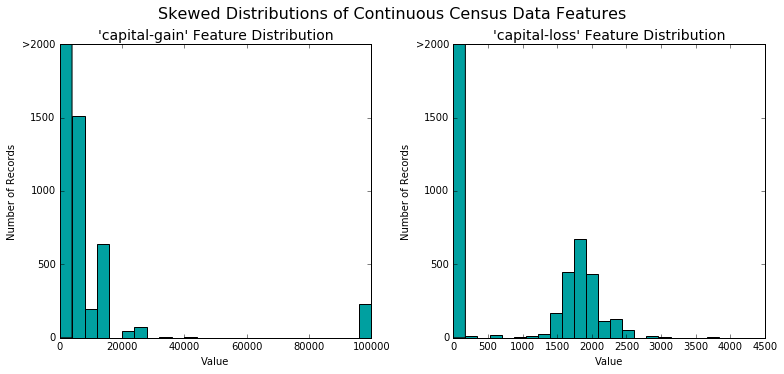

In [6]:
# 转化前
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

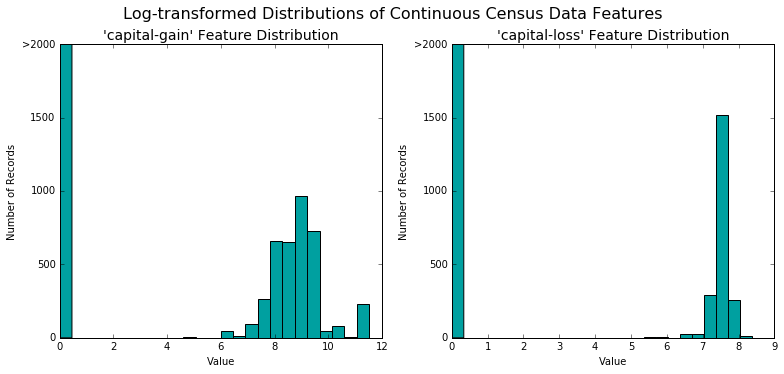

In [7]:
# 转化后
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

#### 2. 数字特征归一化

In [8]:
from sklearn.preprocessing import MinMaxScaler
# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


#### 3.独热编码

In [9]:
# TODO：使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)
display(features.head(5))
# TODO：将'income_raw'编码成数字值
#income = pd.get_dummies(income_raw)，若单纯编码时可以这样，置数时不可以
income = income_raw.str.count('>50K')
#display(income.head(10))
#str.count()遍历income_raw列表，与>50一样的字符串置1，不一样置0
#income = income_raw.replace(['>50K', '<=50K'], [1, 0])
# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


103 total features after one-hot encoding.


#### 4. 混洗切分数据

现在所有的 类别变量 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。其中80%的数据将用于训练和20%的数据用于测试。然后再进一步把训练数据分为训练集和验证集，用来选择和优化模型

In [11]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)
# 此时的训练集已经不包括验证集了

# 显示切分的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Validation set has {} samples.".format(X_val.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


#### 模型探索

#### 1. 天真模型：所有人都大于50k

In [12]:
#不能使用scikit-learn，你需要根据公式自己实现相关计算。
y_val_greater = list(y_val).count(1)
print y_val_greater
#count()是统计列表中某个值的个数

#TODO： 计算准确率
accuracy = y_val_greater/float(len(y_val))

# TODO： 计算查准率 Precision
precision = y_val_greater/float(len(y_val))

# TODO： 计算查全率 Recall
recall = y_val_greater/y_val_greater

# TODO： 使用上面的公式，设置beta=0.5，计算F-score
fscore = (1+np.power(0.5, 2))*precision*recall/(np.power(0.5,2)*precision+recall)

# 打印结果
print "Naive Predictor on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore)

1793
Naive Predictor on validation data: 
     Accuracy score: 0.2478 
     Precision: 0.2478 
     Recall: 1.0000 
     F-score: 0.2917


#### 2. 监督模型

你能够在 [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 中选择以下监督学习模型
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树 (DecisionTree)
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (K Nearest Neighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归（LogisticRegression）

从上面的监督学习模型中选择三个适合我们这个问题的模型，并回答相应问题。

In [13]:
## 从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_val, y_val):
    results = {}
    
    # TODO：使用sample_size大小的训练数据来拟合学习器
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # 获得程序开始时间
    learner = learner.fit(X_train[: sample_size], y_train[: sample_size])
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end - start
    
    # TODO: 得到在验证集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[: 300])
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end - start
            
    # TODO：计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[: 300], predictions_train)
        
    # TODO：计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    # TODO：计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[: 300], predictions_train, beta=0.5)
        
    # TODO：计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, beta=0.5)
       
    # 成功
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # 返回结果
    return results

AdaBoostClassifier trained on 289 samples.
AdaBoostClassifier trained on 2894 samples.
AdaBoostClassifier trained on 28941 samples.
DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
KNeighborsClassifier trained on 289 samples.
KNeighborsClassifier trained on 2894 samples.
KNeighborsClassifier trained on 28941 samples.


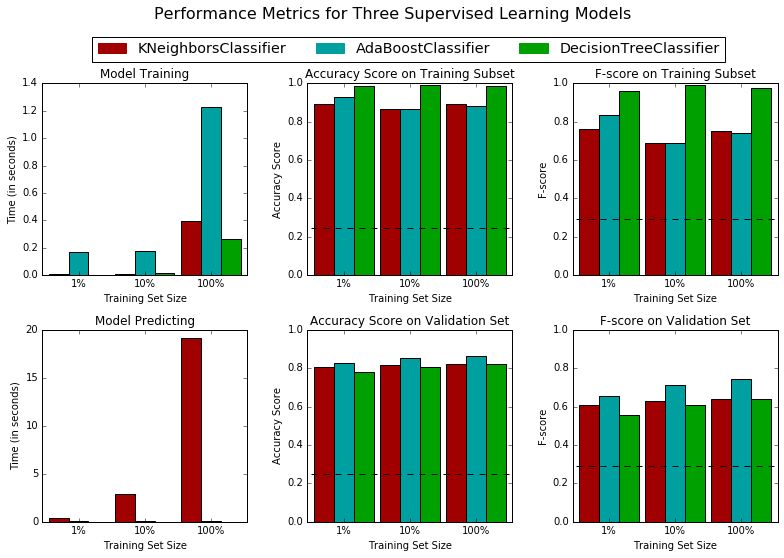

In [14]:
# TODO：从sklearn中导入三个监督学习模型
from sklearn import ensemble
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
# TODO：初始化三个模型
clf_A = ensemble.AdaBoostClassifier(random_state=0)
clf_B = tree.DecisionTreeClassifier(random_state=0)
clf_C = KNeighborsClassifier()

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = int(X_train.shape[0] * 1)

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

In [15]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import ensemble
# TODO：初始化分类器
clf = ensemble.AdaBoostClassifier(random_state=0)

# TODO：创建你希望调节的参数列表
parameters = {'n_estimators': [50, 100, 200], 
              'learning_rate':[0.5, 0.7, 0.8]}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, scorer,cv=10)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_fit = grid_obj.fit(X_train, y_train)
# 得到estimator
best_clf = grid_obj.best_estimator_
print best_clf

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.8, n_estimators=200, random_state=0)
Unoptimized model
------
Accuracy score on validation data: 0.8648
F-score on validation data: 0.7443

Optimized Model
------
Final accuracy score on the validation data: 0.8716
Final F-score on the validation data: 0.7581


#### 提取特征

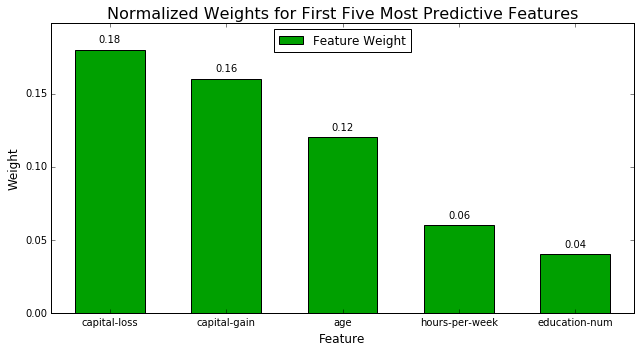

In [16]:
# TODO：在训练集上训练一个监督学习模型
model = ensemble.AdaBoostClassifier(random_state = 0)
model.fit(X_train, y_train)
# TODO： 提取特征重要性
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

In [17]:
## 只用重要特征来训练模型
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)
##clone用于构造具有相同参数的新估计器

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print "Final Model trained on full data\n------"
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions))
print "F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on validation data: 0.8716
F-score on validation data: 0.7581

Final Model trained on reduced data
------
Accuracy on validation data: 0.8391
F-score on validation data: 0.7029


#### 测试集测试所训练的模型

In [18]:
best_predictions = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, best_predictions)
score = fbeta_score(y_test, best_predictions, beta=0.5)
print accuracy, score

0.865339966833 0.747411789563
